# Evaluate Hex Chess Engines

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
from hexchess import HexChessBoard, Player, RandomPlayer, GreedyPlayer
from engines import QNetworkPlayer, A2CPlayer
from utils import make_safe_filename
import tensorflow as tf

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
gpus = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(gpus[0], True)
#print(gpus[0])

In [4]:
# Constants
results_dir = "./assets/results"
os.makedirs(results_dir, exist_ok=True)

## Game Function

In [7]:
def play_game(white_player, black_player, board, max_moves = 50):
    # Reset board
    board.reset()

    # Play game
    n_moves = 0
    turn_is_white = True
    finished = False
    for _ in range(max_moves * 2):
        # Select active player
        active_player = white_player if turn_is_white else black_player

        # Get move
        position_from, position_to = active_player.get_move()
        success, finished = board.move(position_from, position_to, turn_is_white)

        # Update turn
        turn_is_white = not turn_is_white
        n_moves += 1 if turn_is_white else 0
        if finished:
            break

    # Determine winner (only valid if game is finished)
    white_won = not turn_is_white
    return finished, white_won, n_moves

In [8]:
def play_games(
    white_player_class,
    black_player_class,
    max_moves=50,
    n_games=10,
    progress_bar=True,
):
    # Parse player
    if isinstance(white_player_class, dict):
        white_player_kwargs = white_player_class['kwargs']
        white_player_class = white_player_class['class']
    else:
        white_player_kwargs = {}
    if isinstance(black_player_class, dict):
        black_player_kwargs = black_player_class['kwargs']
        black_player_class = black_player_class['class']
    else:
        black_player_kwargs = {}
    
    # Initialize board
    board = HexChessBoard(save_prob=0.)
    
    # Initialize players
    white_player = white_player_class(board, True, **white_player_kwargs)
    black_player = black_player_class(board, False, **black_player_kwargs)
    
    
    # Play games
    fn = tqdm if progress_bar else lambda x: x
    results = [None] * n_games
    for game_index in fn(range(n_games)):
        results[game_index] = play_game(
            white_player=white_player,
            black_player=black_player,
            board=board,
            max_moves=max_moves,
        )

    return results

## Evaluate Games

In [48]:
# Configuration
n_games = 100
max_moves = 100
white_players = [
    {"class": RandomPlayer, "label": "Random (baseline)", "kwargs": {}}, 
    {"class": GreedyPlayer, "label": "Greedy (baseline)", "kwargs": {}},
    {"class": QNetworkPlayer, "label": "Deep Q Learning", "kwargs": {}},
    {"class": A2CPlayer, "label": "Simple Actor Critic", "kwargs": {"model_name": "simple_a2c_random"}},
    {"class": A2CPlayer, "label": "Advanced Actor Critic", "kwargs": {"model_name": "advanced_a2c_random", "residual_blocks": True, "shared_feature_extraction": False, "double_critic": True, "delayed_critic": True, "critic_delay_freq": 5}}
]
n_players = len(white_players)
black_players = white_players

In [49]:
# Gather results
rows = [player["label"] if isinstance(player, dict) else player.name for player in white_players]
cols = [player["label"] if isinstance(player, dict) else player.name for player in black_players]
games_won = np.zeros((len(white_players), len(black_players)), dtype=int)
games_draw = np.zeros((len(white_players), len(black_players)), dtype=int)
games_lost = np.zeros((len(white_players), len(black_players)), dtype=int)
games_moves = np.zeros((len(white_players), len(black_players)), dtype=float)

# All white players
for i, white_player in enumerate(white_players):
    # Against all black players
    for j, black_player in enumerate(black_players):
        # Battle start
        print(f"{white_player['label']} vs {black_player['label']}")
        
        # Make sure we don't already have the results
        results_filename = f"{make_safe_filename(white_player['label'])}_vs_{make_safe_filename(black_player['label'])}_{n_games}.pkl"
        results_filepath = os.path.join(results_dir, results_filename)
        if os.path.exists(results_filepath):
            # Results path exists - load from file
            with open(results_filepath, "rb") as results_file:
                results = pickle.load(results_file)
        else:
            # Results path does not exist - play games
            results = play_games(
                white_player,
                black_player,
                max_moves=max_moves,
                n_games=n_games,
                progress_bar=True,
            )
            # Save to file
            with open(results_filepath, "wb") as results_file:
                pickle.dump(results, results_file)
        
        # Save statistics
        for game_index, result in enumerate(results):
            # Parse result
            game_finished, white_won, n_moves = result
            
            # Win / Loss / Draw
            if game_finished:
                if white_won:
                    games_won[i, j] += 1
                else:
                    games_lost[i, j] += 1
            else:
                games_draw[i, j] += 1

            # Number of moves
            games_moves[i, j] += n_moves / n_games


Random (baseline) vs Random (baseline)
Random (baseline) vs Greedy (baseline)
Random (baseline) vs Deep Q Learning
Random (baseline) vs Simple Actor Critic
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/simple_a2c_random.pth


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


Random (baseline) vs Advanced Actor Critic
Greedy (baseline) vs Random (baseline)
Greedy (baseline) vs Greedy (baseline)
Greedy (baseline) vs Deep Q Learning
Greedy (baseline) vs Simple Actor Critic
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/simple_a2c_random.pth


100%|██████████| 100/100 [00:05<00:00, 19.81it/s]


Greedy (baseline) vs Advanced Actor Critic
Deep Q Learning vs Random (baseline)
Deep Q Learning vs Greedy (baseline)
Deep Q Learning vs Deep Q Learning
Deep Q Learning vs Simple Actor Critic


Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/simple_a2c_random.pth


100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Deep Q Learning vs Advanced Actor Critic
Simple Actor Critic vs Random (baseline)
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/simple_a2c_random.pth


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Simple Actor Critic vs Greedy (baseline)
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/simple_a2c_random.pth


100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


Simple Actor Critic vs Deep Q Learning
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/simple_a2c_random.pth


100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


Simple Actor Critic vs Simple Actor Critic
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/simple_a2c_random.pth
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/simple_a2c_random.pth


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Simple Actor Critic vs Advanced Actor Critic
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/simple_a2c_random.pth
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/advanced_a2c_random.pth


100%|██████████| 100/100 [24:21<00:00, 14.62s/it]  


Advanced Actor Critic vs Random (baseline)
Advanced Actor Critic vs Greedy (baseline)
Advanced Actor Critic vs Deep Q Learning
Advanced Actor Critic vs Simple Actor Critic
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/advanced_a2c_random.pth
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/github/can_chess_with_hexagons_rl/assets/a2c/simple_a2c_random.pth


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]

Advanced Actor Critic vs Advanced Actor Critic


In [50]:
# Collect results in Dataframes
games_won_df = pd.DataFrame(data = games_won, index = rows, columns = cols)
games_lost_df = pd.DataFrame(data = games_lost, index = rows, columns = cols)
games_draw_df = pd.DataFrame(data = games_draw, index = rows, columns = cols)
games_moves_df = pd.DataFrame(data = games_moves, index = rows, columns = cols)

In [51]:
# Save results
games_df_names = ["won", "lost", "draw", "moves"]
games_dfs = [games_won_df, games_lost_df, games_draw_df, games_moves_df]
for name, game_df in zip(games_df_names, games_dfs):
    game_df.to_csv(os.path.join(results_dir, f"games_{name}.csv"), index=True)

In [52]:
# Load results
models = "qnetworks"
games_df_names = ["won", "lost", "draw", "moves"]
games_dfs = [pd.read_csv(os.path.join(results_dir, f"games_{name}.csv"), index_col=0) for name in games_df_names]
games_won_df, games_lost_df, games_draw_df, games_moves_df = games_dfs

In [53]:
print("___GAMES WON___")
games_won_df

___GAMES WON___


,Random (baseline),Greedy (baseline),Deep Q Learning,Simple Actor Critic,Advanced Actor Critic
Random (baseline),38,1,17,35,21
Greedy (baseline),100,41,96,100,100
Deep Q Learning,33,1,0,0,0
Simple Actor Critic,24,0,0,0,0
Advanced Actor Critic,37,0,0,0,0


In [54]:
print("___GAMES LOST___")
games_lost_df

___GAMES LOST___


,Random (baseline),Greedy (baseline),Deep Q Learning,Simple Actor Critic,Advanced Actor Critic
Random (baseline),37,99,65,1,29
Greedy (baseline),0,59,4,0,0
Deep Q Learning,32,99,100,0,0
Simple Actor Critic,32,100,0,0,0
Advanced Actor Critic,34,100,0,0,0


In [55]:
print("___GAMES DRAW___")
games_draw_df

___GAMES DRAW___


,Random (baseline),Greedy (baseline),Deep Q Learning,Simple Actor Critic,Advanced Actor Critic
Random (baseline),25,0,18,64,50
Greedy (baseline),0,0,0,0,0
Deep Q Learning,35,0,0,100,100
Simple Actor Critic,44,0,100,100,100
Advanced Actor Critic,29,0,100,100,100


In [56]:
print("___NET WINS___")
net_wins_df = games_won_df - games_lost_df
net_wins_df

___NET WINS___


,Random (baseline),Greedy (baseline),Deep Q Learning,Simple Actor Critic,Advanced Actor Critic
Random (baseline),1,-98,-48,34,-8
Greedy (baseline),100,-18,92,100,100
Deep Q Learning,1,-98,-100,0,0
Simple Actor Critic,-8,-100,0,0,0
Advanced Actor Critic,3,-100,0,0,0


In [57]:
print("__NR OF MOVES__")
games_moves_df

__NR OF MOVES__


,Random (baseline),Greedy (baseline),Deep Q Learning,Simple Actor Critic,Advanced Actor Critic
Random (baseline),65.55,12.07,41.28,87.60,80.53
Greedy (baseline),11.49,19.68,13.20,16.33,11.24
Deep Q Learning,70.76,10.14,5.00,100.00,100.00
Simple Actor Critic,69.39,17.99,100.00,100.00,100.00
Advanced Actor Critic,62.03,6.00,100.00,100.00,100.00


In [58]:
net_wins = net_wins_df.to_numpy()
white_model_names = net_wins_df.columns.to_numpy()
black_model_names = net_wins_df.index.to_numpy()

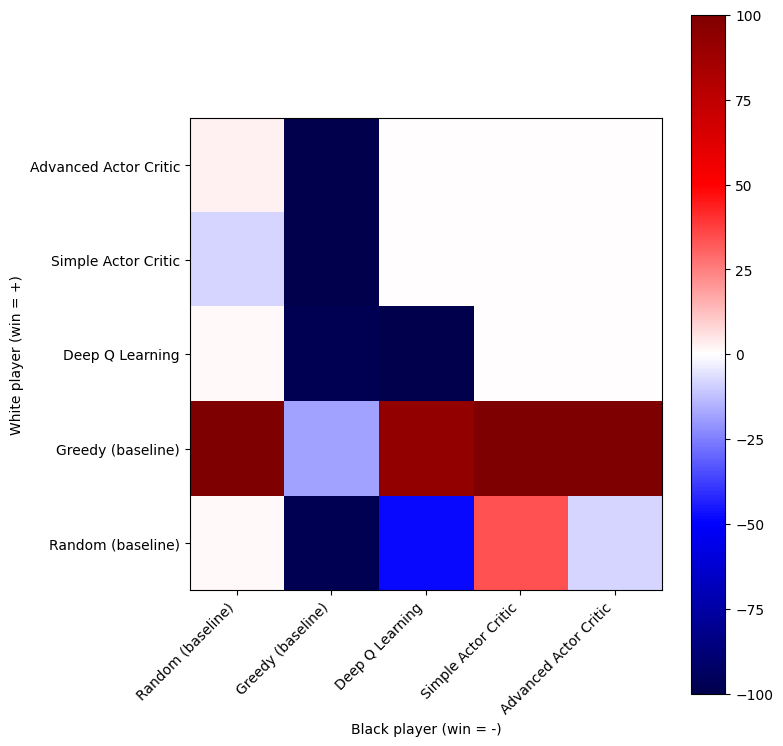

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(net_wins, cmap="seismic", interpolation="none", origin="lower", vmin=-100, vmax=100)
fig.colorbar(img, ax=ax)
ax.set_xticks(np.arange(len(white_model_names)))
ax.set_xticklabels(white_model_names, rotation=45, horizontalalignment="right")
ax.set_yticks(np.arange(len(black_model_names)))
ax.set_yticklabels(black_model_names, rotation=0, horizontalalignment="right")
ax.set_ylabel("White player (win = +)")
ax.set_xlabel("Black player (win = -)")
fig.tight_layout()
fig.savefig(os.path.join(".", "net_wins.png"), dpi=300, facecolor="white")
plt.show()

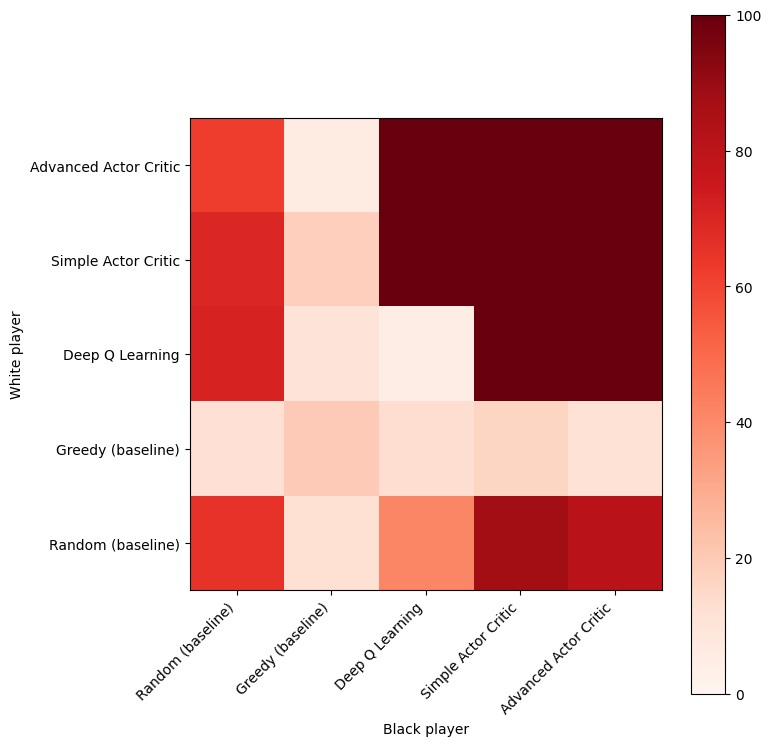

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(games_moves_df.to_numpy(), cmap="Reds", interpolation="none", origin="lower", vmin=0, vmax=100)
fig.colorbar(img, ax=ax)
ax.set_xticks(np.arange(len(white_model_names)))
ax.set_xticklabels(white_model_names, rotation=45, horizontalalignment="right")
ax.set_yticks(np.arange(len(black_model_names)))
ax.set_yticklabels(black_model_names, rotation=0, horizontalalignment="right")
ax.set_ylabel("White player")
ax.set_xlabel("Black player")
fig.tight_layout()
fig.savefig(os.path.join(".", "nr_moves.png"), dpi=300, facecolor="white")
plt.show()